<a href="https://colab.research.google.com/github/NeZorinEgor/PyTorch-Practice/blob/main/MNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
import cv2
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=(0.5), std=(0.5))
])

In [ ]:
dataset_mnist = tv.datasets.MNIST(
    "./datasets",
    download=True,
    transform=transform
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4584377.60it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134711.82it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1106616.28it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3803259.89it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset_mnist,
    [50000, 10000]
)

In [ ]:
train_data, val_data = torch.utils.data.random_split(
    train_dataset,
    [0.8, 0.2]
)

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [38]:
class MNISTModel(nn.Module):
  def __init__(self):
     super().__init__()
     self.layer_1 = nn.Linear(784, 128)
     self.layer_2 = nn.Linear(128, 10)
     self.act = nn.ReLU()

  def forward(self, x):
     x = self.layer_1(x)
     x = self.act(x)
     out = self.layer_2(x)
     return out

model = MNISTModel().to(device)

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [40]:
input = torch.rand([16, 784], dtype=torch.float32).to(device)

out = model(input)
out.shape

torch.Size([16, 10])

In [41]:
epochs = 5
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(epochs):
  # Тренировка
  model.train()
  running_train_loss = []
  true_answer = 0
  train_loop = tqdm(train_loader, leave=False)
  for img, label in train_loop:
    # (batch_size, 1, 28, 28) =>  (batch_size, 784)
    img = img.reshape(-1, 28*28).to(device)
    label = label.reshape(-1).to(torch.int32)
    label = torch.eye(10)[label].to(device)

    # Прямой проход + расчет ошибки
    predict = model(img)
    loss = loss_fn(predict, label)

    # Обратный проход и шаг оптимизации
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_train_loss.append(loss.item())
    mean_train_loss = sum(running_train_loss)/len(running_train_loss)

    true_answer += (predict.argmax(dim=1) == label.argmax(dim=1)).sum().item()

    train_loop.set_description(f"Epoch [{epoch+1}/{epochs}], train_loss={mean_train_loss:.4f}")

  # Расчёт значения метрики
  running_train_acc = true_answer / len(train_data)

  train_loss.append(mean_train_loss)
  train_acc.append(running_train_acc)

  # Проверка модели (валидация)
  model.eval()
  running_val_loss = []
  true_answer = 0
  with torch.no_grad():
    for img, label in val_loader:
      img = img.reshape(-1, 28*28).to(device)
      # (batch_size, int) =>  (batch_size, 10), dtype=float32
      label = label.reshape(-1).to(torch.int32)
      label = torch.eye(10)[label].to(device)

      predict = model(img)
      loss = loss_fn(predict, label)

      running_val_loss.append(loss.item())
      mean_val_loss = sum(running_val_loss) / len(running_val_loss)

      true_answer += (predict.argmax(dim=1) == label.argmax(dim=1)).sum().item()

    running_val_acc = true_answer / len(val_data)
    val_loss.append(mean_val_loss)
    val_acc.append(running_val_acc)

    print(f"Epoch [{epoch + 1}/{epochs}], train_loss={mean_train_loss:.4f}, train_acc={running_train_acc:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}")

Epoch [1/5], train_loss=1.3791, train_acc=0.6995, val_loss=0.7869, val_acc=0.8349


Epoch [2/5], train_loss=0.6134, train_acc=0.8560, val_loss=0.5191, val_acc=0.8702


Epoch [3/5], train_loss=0.4674, train_acc=0.8787, val_loss=0.4366, val_acc=0.8829


Epoch [4/5], train_loss=0.4100, train_acc=0.8878, val_loss=0.3958, val_acc=0.8903


Epoch [5/5], train_loss=0.3787, train_acc=0.8943, val_loss=0.3729, val_acc=0.8950


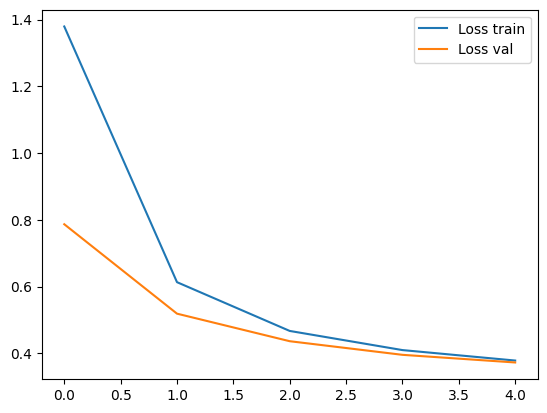

In [44]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["Loss train", "Loss val"])
plt.show()

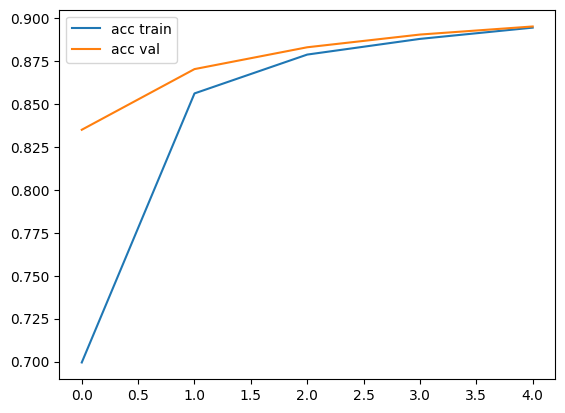

In [46]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["acc train", "acc val"])
plt.show()